# Example 2: A Hybrid Neuroptimiser with a problem from COCO
This example demonstrates how to use the Neuroptimiser library to solve an optimisation problem from the COCO framework. The problem is defined by its ID and instance, and the Neuroptimiser is configured with a set of parameters for the agents.

## 1. Setup
Import necessary libraries and set up the environment for plotting.

In [1]:
# Import necessary libraries
import os
import shutil
from copy import deepcopy
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from neuroptimiser import NeurOptimiser
import cocoex as ex

# Set up the plotting style and parameters
width = 6.5
height = width * 0.618
res_dpi = 333

seed = 42
random.seed(seed)
np.random.seed(seed)

root_figures = "./figures/"

plt.style.context('paper')
sns.set_style("ticks")
plt.rcParams['font.family']         = 'serif'
plt.rcParams['axes.labelsize']      = 11
plt.rcParams['xtick.labelsize']     = 11
plt.rcParams['ytick.labelsize']     = 11
plt.rcParams['legend.fontsize']     = 11
plt.rcParams['axes.grid']           = False
plt.rcParams['axes.spines.top']     = True
plt.rcParams['axes.spines.right']   = True
plt.rcParams['axes.edgecolor']      = 'black'
plt.rcParams['xtick.color']         = 'black'
plt.rcParams['ytick.color']         = 'black'
plt.rcParams['axes.labelcolor']     = 'black'

if shutil.which("pdflatex") is not None:
    plt.rcParams['text.usetex']     = True
    plt.rcParams['font.serif']      = ['Computer Modern Roman']
else:
    plt.rcParams['text.usetex']     = False

def save_this(fig, _in=""):
    if is_saving:
        os.makedirs(f"{root_figures}/" + _in, exist_ok=True)
        fig.savefig(root_figures + _in + "/" + prefix_filename + ".png", transparent=True, dpi=res_dpi, bbox_inches="tight")
    else:
        plt.show()

## 2. Parameter definition
In this section, we define the problem parameters, including the number of steps, problem ID, instance, dimensions. In addition, we set the custom parameters for the Neuroptimiser, which will replace the default parameters of the spiking core.

In [2]:
# Define the problem parameters
num_steps       = 1000       # Number of iterations
problem_id      = 0        # Problem ID from the BBOB framework
problem_ins     = 1         # Problem instance
num_dimensions  = 2         # Number of dimensions for the problem
num_agents      = 30        # Number of agents/units in the Neuroptimiser
num_neighbours  = 15        # Number of neighbours for each agent/unit

coco_suite      = "bbob-noisy"

# Define the Neuroptimiser parameters
neuropt_name    = "neuropt_Ex2-Hyb"

config_params = dict(
    num_iterations  = num_steps,
    num_agents      = num_agents,
    spiking_core    = "TwoDimSpikingCore",
    num_neighbours  = num_neighbours,
    neuron_topology = "2dr",
    unit_topology   = "random",
)

# Proportion of custom spiking cores
proportion_dist = [0.6, 0.4]
neuropt_custom_params = [   # Specify the custom parameters for the spiking cores
    {"name": "linear",
     "coeffs": "random",
     "spk_cond": "l2",
     "hs_operator": "differential",
     "hs_variant": "current-to-best"
     },
    {"name": "linear",
     "coeffs": "repeller",
     "spk_cond": "l2",
     "hs_operator": "differential",
     "hs_variant": "rand-to-best",
     },
    # {"name": "izhikevich",
    #  "coeffs": "random",
    #  "spk_cond": "fixed",
    #  "hs_operator": "differential",
    #  "hs_variant": "current-to-pbest",
    #  },
]

# Additional parameters
is_saving       = True      # Whether to save the figures or not
prefix_filename = (f"{neuropt_name}_"
                   f"{problem_id}p_"
                   f"{problem_ins}i_"
                   f"{num_dimensions}d_"
                   f"{num_steps}s_"
                   f"{num_agents}u")
plt.close()
if is_saving:
    print(f"prefix_filename: '{prefix_filename}'")

prefix_filename: 'neuropt_Ex2-Hyb_0p_1i_2d_1000s_30u'


Process the default parameters for the spiking core and applies any custom parameters specified in `neuropt_custom_params`.

In [3]:
# Set up the default core parameters for the Neuroptimiser
default_core_params = dict(
    alpha       = 1.0,
    dt          = 0.01,
    max_steps   = num_steps,
    noise_std   = (0.0, 0.3),
    ref_mode    = "pgn",
    is_bounded  = True,
    name        = "linear",
    coeffs      = "random",
    approx      = "rk4",
    thr_mode    = "fixed",
    thr_alpha   = 1.0,
    thr_min     = 1e-6,
    thr_max     = 1.0,
    thr_k       = 0.05,
    spk_cond    = "fixed",
    spk_alpha   = 0.25,
    hs_operator = "fixed",
    hs_variant  = "current-to-rand",
)

# Process the custom parameters for the Neuroptimiser
if neuropt_custom_params is None:
    neuropt_custom_params = [{}]

custom_params_indices = np.random.choice(a=range(len(neuropt_custom_params)), size=num_agents, p=proportion_dist)

core_params = []
for i in range(num_agents):
    p = deepcopy(default_core_params)
    override = neuropt_custom_params[custom_params_indices[i]]
    # override = neuropt_custom_params[i % len(neuropt_custom_params)]
    p.update(override)
    core_params.append(p)

## 3. Problem setup and optimisation
We first retrieve the problem from the IOH framework.

In [4]:
# Get the problem from the COCO framework
observer    = ex.Observer("bbob", "result_folder: %s_on_%s" % (neuropt_name, "bbob2009"))
suite       = ex.Suite(coco_suite, "", f"dimensions:{num_dimensions} instance_indices:{problem_ins}")
problem     = suite.get_problem(problem_id)

problem.observe_with(observer)
# problem.free()
print(problem)

bbob_noisy_f101_i01_d02: a 2-dimensional single-objective problem (problem 0 of suite "b'bbob-noisy'" with name "bbob(gaussian_noise_model(BBOB-NOISY suite problem f101 instance 1 in 2D))")
COCO INFO: Results will be output to folder exdata/neuropt_Ex2-Hyb_on_bbob2009-0084


Then, we instantiate the Neuroptimiser with the defined parameters and solve the problem. The `debug_mode` is set to `True` to enable detailed logging of the optimisation process.

In [5]:
# Instantiation
optimiser = NeurOptimiser(config_params, core_params)

# Solve the problem
optimiser.solve(problem, debug_mode=True)

[neuropt:log] Debug mode is enabled. Monitoring will be activated.
[neuropt:log] Parameters are set up.
[neuropt:log] Initial positions and topologies are set up.
[neuropt:log] Tensor contraction layer, neighbourhood manager, and high-level selection unit are created.
[neuropt:log] Population of nheuristic units is created.
[neuropt:log] Connections between nheuristic units and auxiliary processes are established.
[neuropt:log] Monitors are set up.
[neuropt:log] Starting simulation with 1000 iterations...
... step: 0, best fitness: 82.32593536376953
... step: 100, best fitness: 79.4800033569336
... step: 200, best fitness: 79.4800033569336
... step: 300, best fitness: 79.4800033569336
... step: 400, best fitness: 79.4800033569336
... step: 500, best fitness: 79.4800033569336
... step: 600, best fitness: 79.4800033569336
... step: 700, best fitness: 79.4800033569336
... step: 800, best fitness: 79.4800033569336
... step: 900, best fitness: 79.4800033569336
... step: 999, best fitness: 7

(array([ 0.2507188 , -1.15720928]), 79.4800033569336)

In [6]:
# Show the overall configuration parameters of the optimiser
print(optimiser.config_params)

{'num_iterations': 1000, 'num_agents': 30, 'spiking_core': 'TwoDimSpikingCore', 'num_neighbours': 15, 'neuron_topology': '2dr', 'unit_topology': 'random', 'search_space': array([[-5.,  5.],
       [-5.,  5.]]), 'seed': 69, 'function': <function AbstractSolver._rescale_problem.<locals>.scaled_problem at 0x121e43f40>, 'num_dimensions': 2, 'core_params': {}}


In [7]:
# Show the core parameters used in the optimisation
pd.DataFrame(optimiser.core_params)

,alpha,dt,max_steps,noise_std,ref_mode,is_bounded,name,coeffs,approx,thr_mode,...,thr_max,thr_k,spk_cond,spk_alpha,hs_operator,hs_variant,spk_weights,spk_q_ord,seed,init_position
0,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,random,rk4,fixed,...,1.0,0.05,l2,0.25,differential,current-to-best,"[0.5, 0.5]",2,69,"[0.21508970380287673, -0.6589517526254169]"
1,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,repeller,rk4,fixed,...,1.0,0.05,l2,0.25,differential,rand-to-best,"[0.5, 0.5]",2,70,"[-0.869896814029441, 0.8977710745066665]"
2,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,repeller,rk4,fixed,...,1.0,0.05,l2,0.25,differential,rand-to-best,"[0.5, 0.5]",2,71,"[0.9312640661491187, 0.6167946962329223]"
3,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,random,rk4,fixed,...,1.0,0.05,l2,0.25,differential,current-to-best,"[0.5, 0.5]",2,72,"[-0.39077246165325863, -0.8046557719872323]"
4,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,random,rk4,fixed,...,1.0,0.05,l2,0.25,differential,current-to-best,"[0.5, 0.5]",2,73,"[0.3684660530243138, -0.1196950125207974]"
5,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,random,rk4,fixed,...,1.0,0.05,l2,0.25,differential,current-to-best,"[0.5, 0.5]",2,74,"[-0.7559235303104423, -0.00964617977745963]"
6,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,random,rk4,fixed,...,1.0,0.05,l2,0.25,differential,current-to-best,"[0.5, 0.5]",2,75,"[-0.9312229577695632, 0.8186408041575641]"
7,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,repeller,rk4,fixed,...,1.0,0.05,l2,0.25,differential,rand-to-best,"[0.5, 0.5]",2,76,"[-0.48244003679996617, 0.32504456870796394]"
8,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,repeller,rk4,fixed,...,1.0,0.05,l2,0.25,differential,rand-to-best,"[0.5, 0.5]",2,77,"[-0.3765778478211781, 0.040136042355621626]"
9,1.0,0.01,1000,"(0.0, 0.3)",pgn,True,linear,repeller,rk4,fixed,...,1.0,0.05,l2,0.25,differential,rand-to-best,"[0.5, 0.5]",2,78,"[0.0934205586865593, -0.6302910889489459]"


## 4. Results processing and visualisation
In this section, we process the results of the optimisation and visualise them using various plots. The results include the fitness values, agent positions, and phase portraits.

In [8]:
# Recover the results from the optimiser
fp              = optimiser.results["fp"]
fg              = optimiser.results["fg"]
positions       = np.array(optimiser.results["p"])
best_position   = np.array(optimiser.results["g"])
v1              = np.array(optimiser.results["v1"])
v2              = np.array(optimiser.results["v2"])

# Convert the spikes to integer type
spikes          = np.array(optimiser.results["s"]).astype(int)

# Print some minimal information about the results
print(f"fg: {fg[-1][0]:.4f}")
print(f"{v1.min():.4f} <= v1 <= {v1.max():.4f}")
print(f"{v2.min():.4f} <= v2 <= {v2.max():.4f}")

fg: 79.4800
-1.0505 <= v1 <= 1.3450
-1.2707 <= v2 <= 1.3450


### Error convergence
This plot shows the convergence of the absolute error in fitness values over the iterations of the optimisation process.

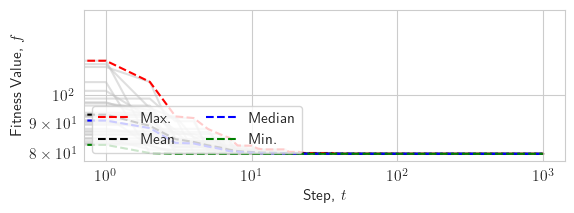

In [9]:
fig, ax = plt.subplots(figsize=(width*0.9, height/1.8))

plt.plot(fp, color="silver", alpha=0.5)
plt.plot(np.max(fp, axis=1), '--', color="red", label=r"Max.")
plt.plot(np.average(fp, axis=1), '--', color="black", label=r"Mean")
plt.plot(np.median(fp, axis=1), '--', color="blue", label=r"Median")
plt.plot(fg, '--', color="green", label=r"Min.")

plt.xlabel(r"Step, $t$")
plt.ylabel(r"Fitness Value, $f$")

lgd = plt.legend(ncol=2, loc="lower left")

plt.xscale("log")
plt.yscale("log")

ax.patch.set_alpha(0)
fig.tight_layout()

save_this(fig, _in="fitness")

### Position evolution in 2D
This plot shows the evolution of the unit positions in the 2D space over the iterations of the optimisation process.

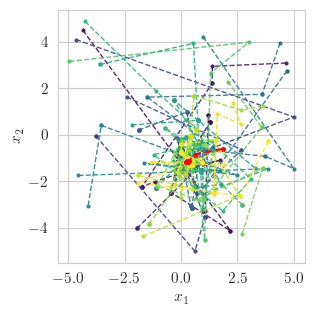

In [10]:
fig, ax = plt.subplots(figsize=(width/2, width/2))

cmap = plt.get_cmap('viridis', num_agents)
color = cmap(np.linspace(0, 1, num_agents))

for agent, c in enumerate(color):
    plt.plot(positions[:, agent, 0], positions[:,agent, 1], "--o",
             color=c, alpha=0.9, markersize=2, linewidth=1,
             label=f"Agent {agent}")

plt.plot(best_position[:, 0], best_position[:, 1], "--*",
         color="red", markersize=3, label="Best position")

# plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

ax.patch.set_alpha(0)
fig.tight_layout()

save_this(fig, _in="positions_2d")

### Position evolution in 3D
This plot shows the evolution of the unit positions in the 3D space over the iterations of the optimisation process.

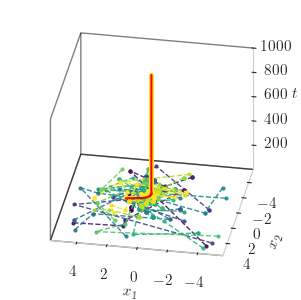

In [11]:
fig = plt.figure(figsize=(width/2, width/2))

ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('ortho')

cmap = plt.get_cmap('viridis', num_agents)
color = cmap(np.linspace(0, 1, num_agents))

steps = np.arange(optimiser._num_iterations) + 1

for agent, c in enumerate(color):
    ax.plot3D(positions[:, agent, 0], positions[:, agent, 1], steps,
              "--o", color=c, alpha=0.9, markersize=2, linewidth=1,
              label=f"Agent {agent}")

ax.plot3D(best_position[:, 0], best_position[:, 1], steps,
          "-", color="red", markersize=2,  linewidth=1.5,
          label="Best position")

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.pane.set_edgecolor('black')
    axis.pane.set_linewidth(1.0)

# ax.viewfig, _init(elev=35, azim=135)
ax.view_init(elev=30, azim=100)
# ax.legend()
ax.set_xlabel(r"$x_1$", labelpad=1)
ax.set_ylabel(r"$x_2$", labelpad=1)
ax.set_zlabel(r"$t$", labelpad=0)
ax.set_box_aspect([1, 1, 0.8])

ax.set_zlim(1, num_steps)

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.patch.set_alpha(0)
fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
# fig.tight_layout()

save_this(fig, _in="positions_3d")

### Phase portrait
This section visualises the phase portrait of the optimisation process in 2D. The phase portrait shows the trajectory of each agent in the 2D space over the iterations.

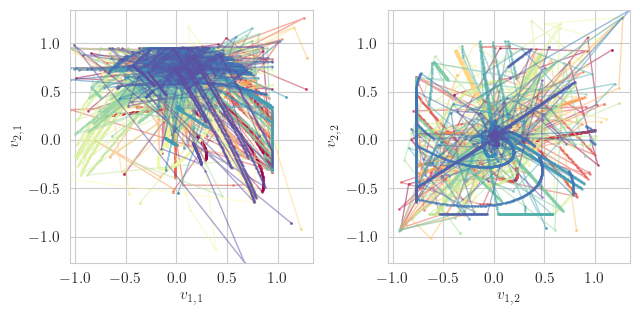

In [12]:
fig, axs = plt.subplots(nrows=np.ceil(num_dimensions / 2).astype(int),
                        ncols=2, figsize=(width, width/2))

steps = np.arange(optimiser._num_iterations) + 1
cmap = plt.get_cmap('Spectral', num_agents)
color = cmap(np.linspace(0, 1, num_agents))

for i, ax in enumerate(axs.flatten()):

    for agent, c in enumerate(color):
        ax.plot(v1[agent, :, i], v2[agent, :, i], "-o",
                color=c, alpha=0.5, markersize=1, linewidth=1,
                label=f"Agent {agent}")
        ax.plot(v1[agent, 0, i], v2[agent, 0, i], "-s",
                color=c, alpha=0.5, markersize=1, linewidth=1,
                label=f"Agent {agent}")

    ax.set_xlabel(r"$v_{}$".format("{1," + str(i+1) + "}"))
    ax.set_ylabel(r"$v_{}$".format("{2," + str(i+1) + "}"))

    ax.set_xlim(v1.min(), v1.max())
    ax.set_ylim(v2.min(), v2.max())

    ax.patch.set_alpha(0)

fig.tight_layout()

save_this(fig, _in="portrait_2d")

### Phase portrait in 3D
This section visualises the phase portrait of the optimisation process in 3D. The phase portrait shows the trajectory of each agent in the 3D space over the iterations.

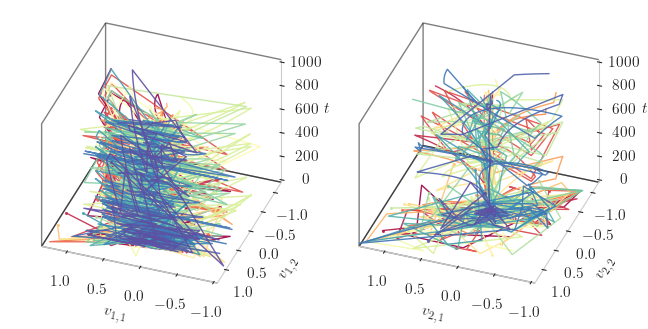

In [13]:
fig = plt.figure(figsize=(width, width/2))

num_rows = np.ceil(num_dimensions / 2).astype(int)
num_cols = 2

axs = [
    fig.add_subplot(
        num_rows, num_cols, i + 1, projection='3d'
    ) for i in range(num_dimensions)
]

steps = np.arange(optimiser._num_iterations) + 1
cmap = plt.get_cmap('Spectral', num_agents)
color = cmap(np.linspace(0, 1, num_agents))

for i, ax in enumerate(axs):
    ax.set_proj_type('ortho')
    ax.set_box_aspect([1, 1, 0.8])
    ax.view_init(elev=35, azim=110)

    for agent, c in enumerate(color):
        ax.plot3D(v1[agent, :, i], v2[agent, :, i], steps, "-",
                  color=c, alpha=0.9,
                  markersize=1, linewidth=1,
                  label=f"Agent {agent}")

        ax.plot3D(v1[agent, 0, i], v2[agent, 0, i], 0, "-s",
                  color=c, alpha=0.9,
                  markersize=1, linewidth=1,
                  label=f"Agent {agent}")

    ax.set_xlabel(r"$v_{}$".format("{" + str(i+1) + ",1}"))
    ax.set_ylabel(r"$v_{}$".format("{" + str(i+1) + ",2}"))
    ax.set_zlabel(r"$t$", labelpad=0.1)

    ax.set_xlim(v1.min(), v1.max())
    ax.set_ylim(v2.min(), v2.max())

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.pane.set_edgecolor('black')
        axis.pane.set_linewidth(1.0)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.patch.set_alpha(0)

fig.tight_layout()

save_this(fig, _in="portrait_3d")

### Spike activity heatmap
This section visualises the spike activity of the agents over the iterations of the optimisation process. The heatmap shows the summed spike counts across all dimensions for each agent at each step.

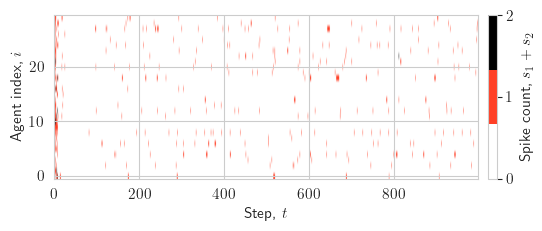

In [14]:
fig, ax = plt.subplots(figsize=(width*0.9, height * 0.6))

spikes_sum = np.sum(spikes, axis=2)
cmap = plt.get_cmap("CMRmap_r", 3)
im = ax.imshow(spikes_sum.T, aspect='auto', origin='lower',
               cmap=cmap, vmin=0, vmax=2)

ax.set_xlabel(r"Step, $t$")
ax.set_ylabel(r"Agent index, $i$")

cbar = fig.colorbar(im, ax=ax, pad=0.02, ticks=[0, 1, 2])
cbar.set_label(r"Spike count, $s_{1}+s_{2}$")

ax.patch.set_alpha(0)
fig.tight_layout()

save_this(fig, _in="spikes_hm")

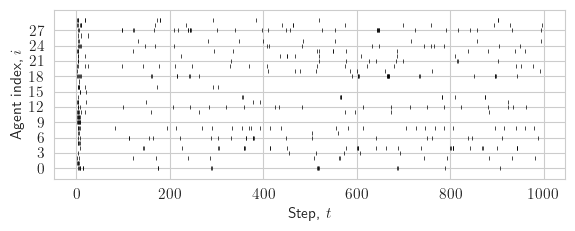

In [15]:
fig, ax = plt.subplots(figsize=(width*0.9, height*0.6))

# spikes: (T, A, D) -> per-agent list of spike times
events = []
for i in range(num_agents):
    # any spike on any dimension at step t?
    t_idx = np.where(spikes[:, i, :].any(axis=1))[0]
    events.append(t_idx)

# eventplot expects a list of 1D arrays
ax.eventplot(events, orientation='horizontal', linelengths=0.8, linewidths=0.5, colors='black')

ax.set_xlabel(r"Step, $t$")
ax.set_ylabel(r"Agent index, $i$")
ax.set_ylim(-2.0, num_agents + 1.0)
ax.set_yticks(np.arange(0, num_agents, max(1, num_agents // 10)))

ax.patch.set_alpha(0)
fig.tight_layout()
save_this(fig, _in="spikes_raster_agents")

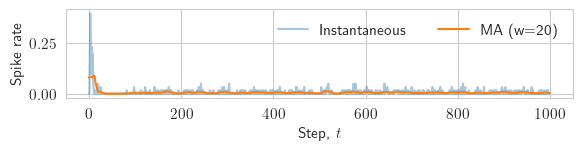

In [16]:
window = max(5, num_steps // 50)  # choose a small window
# mean activity per step (across agents and dims)
rate = spikes.mean(axis=(1, 2)).astype(float)

# simple moving average
kernel = np.ones(window) / window
rate_ma = np.convolve(rate, kernel, mode='same')

fig, ax = plt.subplots(figsize=(width*0.9, height*0.4))
ax.plot(np.arange(num_steps), rate, alpha=0.4, label="Instantaneous")
ax.plot(np.arange(num_steps), rate_ma, linewidth=1.5, label=f"MA (w={window})")

ax.set_xlabel(r"Step, $t$")
ax.set_ylabel(r"Spike rate")
ax.legend(loc="upper right", ncol=2, frameon=False)

ax.patch.set_alpha(0)
fig.tight_layout()
save_this(fig, _in="spikes_rate_ma")